In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [68]:
df=pd.read_parquet("df.sample.parquet.gzip",)

In [69]:
df = df.drop('category_id', axis=1)


In [70]:
df.shape,df.dtypes

((1000000, 7),
 event_time       datetime64[ns, UTC]
 event_type                  category
 product_id                     int64
 category_code                 object
 brand                         object
 price                        float32
 user_id                        int64
 dtype: object)

In [71]:
df.sample(10)

,event_time,event_type,product_id,category_code,brand,price,user_id
1694920,2019-10-17 15:06:44+00:00,view,28719065,apparel.shoes,baden,113.000000,512412071
6944104,2019-10-21 07:15:32+00:00,view,1004258,electronics.smartphone,apple,757.570007,544358080
3148383,2019-10-28 17:03:11+00:00,view,2800433,appliances.kitchen.refrigerators,haier,283.119995,546229695
4138775,2019-10-29 14:17:40+00:00,view,6301402,appliances.kitchen.kettle,willmark,7.700000,513185595
4379233,2019-10-19 12:13:39+00:00,purchase,5700846,auto.accessories.player,pioneer,342.350006,538447504
1235750,2019-10-17 09:09:25+00:00,view,1004856,electronics.smartphone,samsung,131.639999,561147490
1501895,2019-10-07 16:38:01+00:00,view,1701478,computers.peripherals.monitor,philips,198.130005,518697192
4117659,2019-10-19 08:50:45+00:00,view,1003317,electronics.smartphone,apple,951.989990,561838593
907639,2019-10-01 16:00:20+00:00,view,13901778,construction.components.faucet,bravat,179.110001,519458051
5120036,2019-10-25 03:25:46+00:00,view,1307310,computers.notebook,acer,283.119995,563888695


In [72]:
# "CustomerID" 가 있고 "Quantity" , "UnitPrice"가 0보다 큰 데이터를 가져옵니다.
# 구매하고 취소한 건 중 취소한 건만 제외하고 구매 건은 남깁니다.
df_valid = df[df["user_id"].notnull() 
                & (df["product_id"] > 0)].copy()
df_valid.shape

(1000000, 7)

In [73]:
df[df['price'] == 0]['event_type'].unique()

['view', 'cart']
Categories (3, object): ['cart', 'purchase', 'view']

In [74]:
df['event_time'] 

6733995   2019-10-06 08:34:28+00:00
4880941   2019-10-10 08:31:52+00:00
6895456   2019-10-26 08:07:34+00:00
807139    2019-10-07 06:33:45+00:00
6297826   2019-10-25 18:07:49+00:00
                     ...           
6869328   2019-10-06 10:23:48+00:00
3558299   2019-10-09 08:26:06+00:00
1358710   2019-10-07 15:03:40+00:00
471300    2019-10-01 09:56:51+00:00
3615460   2019-10-29 06:05:56+00:00
Name: event_time, Length: 1000000, dtype: datetime64[ns, UTC]

<AxesSubplot:xlabel='price'>

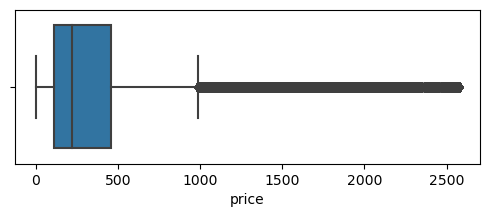

In [15]:
# 이상치를 탐색해 보는 방법 - 박스플롯 그리기
plt.figure(figsize=(6,2))
sns.boxplot(data=df,x="price")

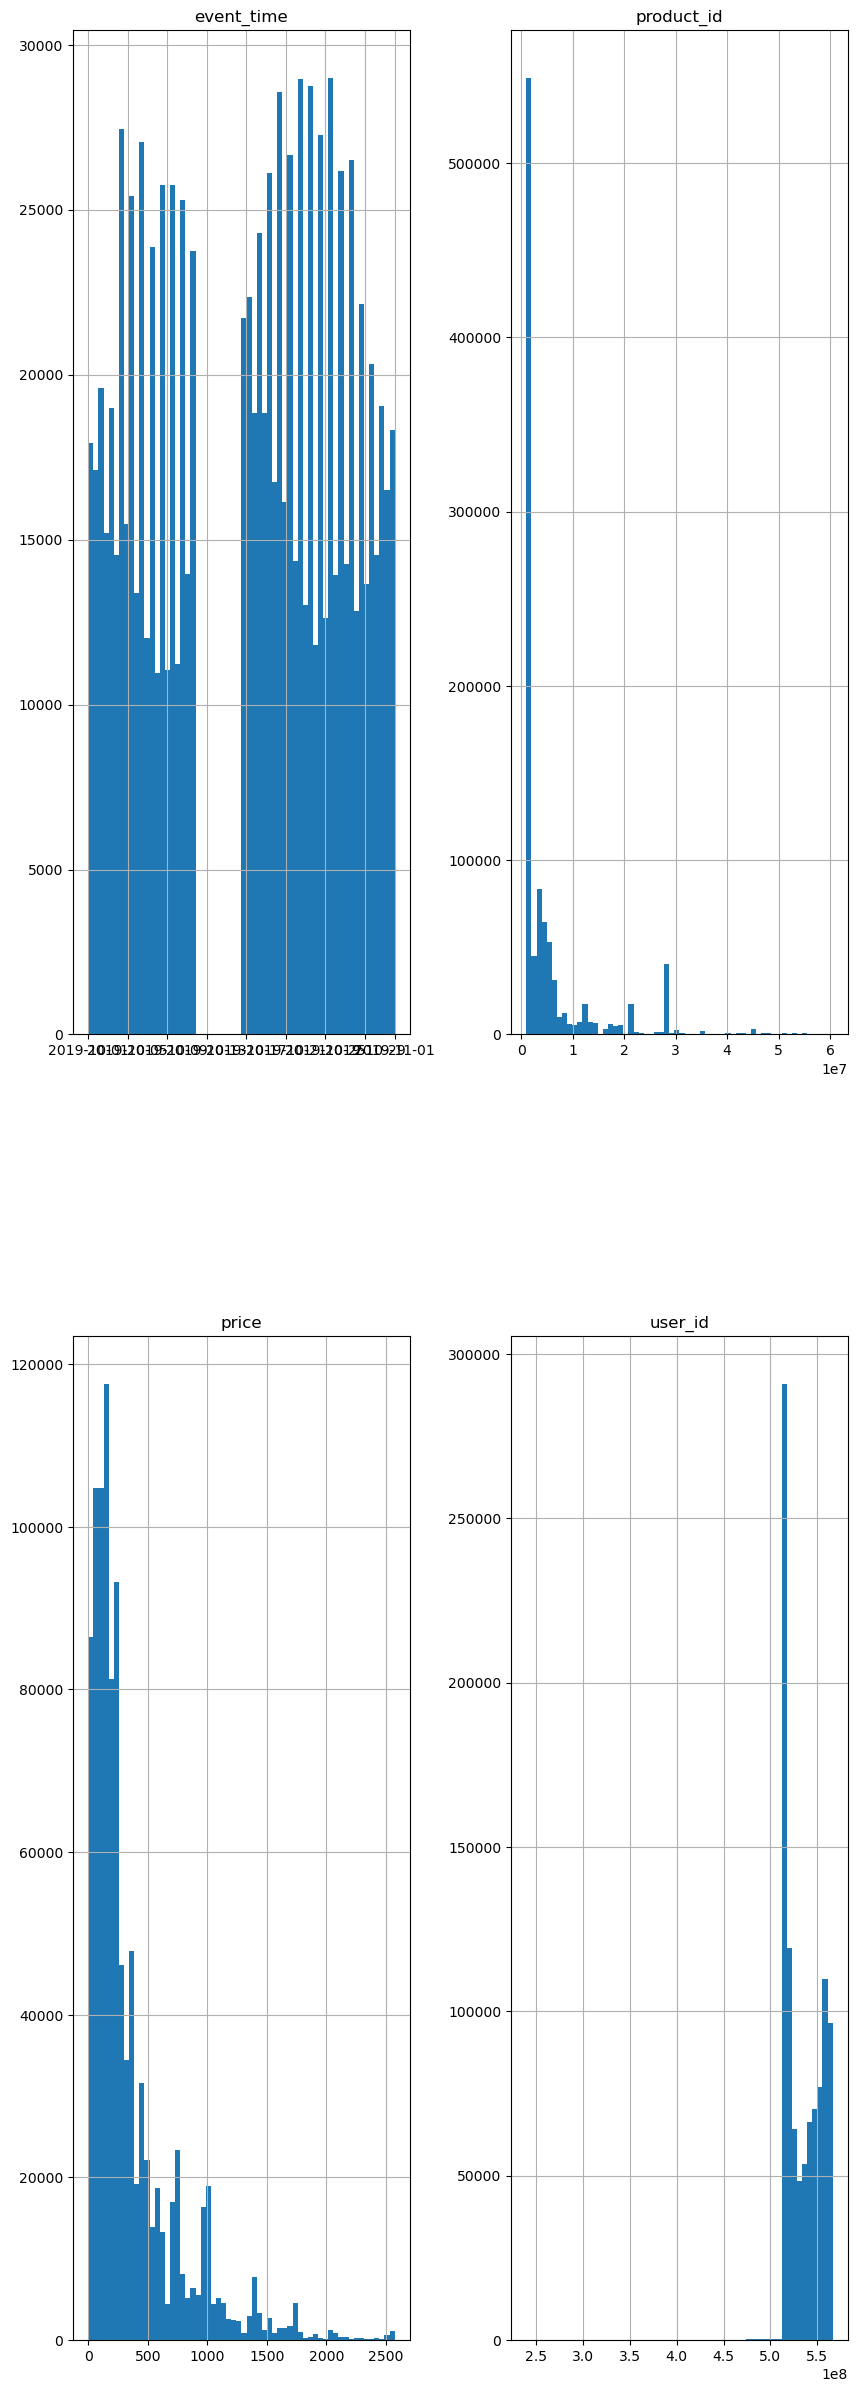

In [29]:
df.hist(bins=60, figsize=(10, 30));

In [80]:
# event_time 에서 앞에서 19개문자만 가져오면([:7]) 연, 월,일 시간 분 초 가져오기
df['event_time']=df['event_time'].astype(str).str[:19]


In [81]:
df.head(1)

,event_time,event_type,product_id,category_code,brand,price,user_id
6733995,2019-10-06 08:34:28,view,16700605,furniture.kitchen.chair,zeta,16.190001,518195082


In [83]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [90]:
# Recency 계산을 위해 해당 주문에서 가장 최근 구매가 일어난 시간을 가져옵니다.
# 최근 거래 기준일(last_timestamp)을 만들기 위해 timedelta로 날짜를 더해줍니다.(최소값:1 설정)
# timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
last_timestamp = df['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:59:58')

# 고객별 Recency, Frequency, Monetary 값 구하기

In [91]:
(last_timestamp - df.iloc[0]["event_time"]).days

26

In [92]:
# RFM 값을 정의합니다.
# Recency : 최근 거래 기준일(last_timestamp)과 고객별 최근 구매한 날짜(x.max())와 차이값
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
rfm = df.groupby("user_id").agg({"event_time" : lambda x : (last_timestamp - x.max()).days,
                                    "product_id" : "count", 
                                    "price": "sum"})
rfm.head(3)

,event_time,product_id,price
user_id,,,
239876607,23,1,151.360001
240522111,11,2,350.580017
244951053,29,1,1415.479980


In [95]:
rfm = rfm.rename(columns={"event_time": "Recency", 
                          "product_id": "Frequency", 
                          "price": "MonetaryValue"})
rfm.head()

,Recency,Frequency,MonetaryValue
user_id,,,
239876607,23,1,151.360001
240522111,11,2,350.580017
244951053,29,1,1415.479980
265601964,24,1,565.669983
266703857,5,1,16.959999


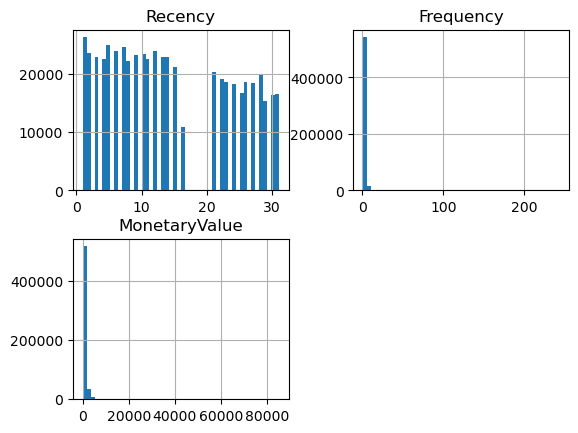

In [96]:
# 히스토그램은 cut 방식입니다. 
# => 한쪽에 고객이 치우쳐져있어서 몰려있는 부분을 제대로 분석하기 어렵기 때문에 고르게 분포가 되도록 분석해볼 예정입니다.
rfm.hist(bins=50);

In [97]:
cut_size=5
r_cut = pd.qcut(rfm['Recency'].rank(method='first'), cut_size, labels=list(range(5,0,-1)))
f_cut = pd.qcut(rfm['Frequency'].rank(method='first'), cut_size, labels=list(range(1,6)))
m_cut = pd.qcut(rfm['MonetaryValue'].rank(method='first'), cut_size, labels=list(range(1,6)))

In [98]:
# assign 을 사용하면 여러 변수를 한 번에 만들 수 있습니다.
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
239876607,23,1,151.360001,2,1,2
240522111,11,2,350.580017,3,4,3
244951053,29,1,1415.479980,1,1,5
265601964,24,1,565.669983,2,1,4
266703857,5,1,16.959999,5,1,1
...,...,...,...,...,...,...
566278951,1,1,229.899994,5,4,2
566279833,1,1,254.779999,5,4,3
566279973,1,1,160.570007,5,4,2


# RFM Segment

In [99]:
# RFM_segment 값을 구합니다. 
# R, F, M 값을 문자 그대로 붙여서 세그먼트를 구분합니다.
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

# RFM Score

In [102]:
# R, F, M 값의 합계를 구해서 세그먼트 점수를 구합니다.
rfm["RFM_score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
239876607,23,1,151.360001,2,1,2,212,5
240522111,11,2,350.580017,3,4,3,343,10


<AxesSubplot:xlabel='RFM_segment', ylabel='RFM_score'>

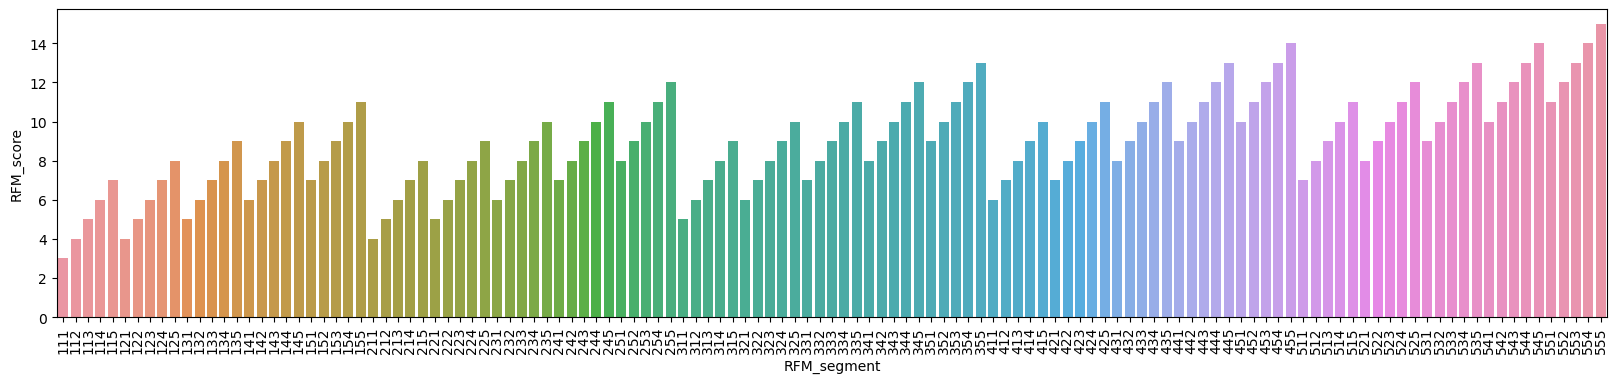

In [103]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values("RFM_segment"), x="RFM_segment", y="RFM_score")

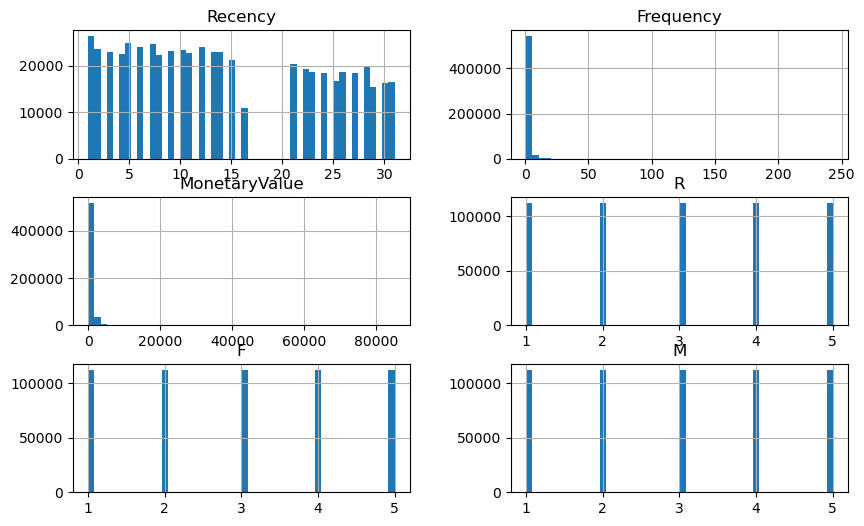

In [104]:
# RFM 을 구간화 하면 기존에 몰려있던 데이터가 같은 비율로 나뉜 것을 볼 수 있습니다.
rfm.iloc[:, :-2].astype(float).hist(figsize=(10, 6), bins=50);

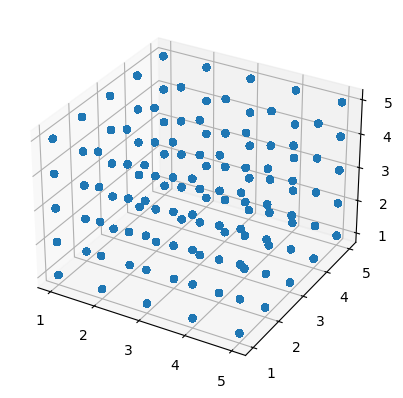

In [105]:
# 3d projection ax.scatter3D rfm["R"], rfm["F"], rfm["M"]
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["R"], rfm["F"], rfm["M"])

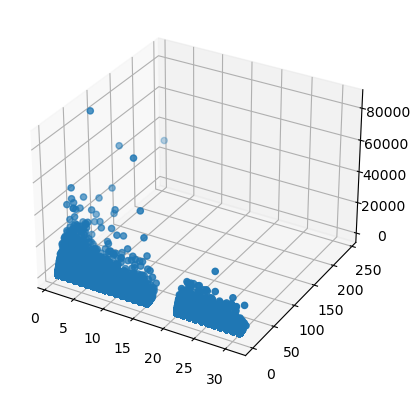

In [106]:
# rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"]
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"])

In [107]:
rfm.columns

Index(['Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M', 'RFM_segment',
       'RFM_score'],
      dtype='object')

In [108]:
# Recency : 최근 거래 기준일(last_timestamp)과 고객별 최근 구매한 날짜(x.max())와 차이값
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
# 문자열의 format 함수를 사용하여 소수점 아래는 표기하지 않도록({:,.0f}) 문자열 포맷을 지정합니다.
rfm.groupby("RFM_score").agg({"Recency": "mean", 
                              "Frequency" : "mean", 
                              "MonetaryValue" : ["mean", "sum"]
                             }).style.background_gradient().format("{:,.0f}")

In [109]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나눕니다. 
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 
                           q=3, 
                           labels=["silver", "gold", "platinum"])

In [110]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe() 값을 구합니다.
# RFM_score 에 따라 RFM_class 값이 잘 나뉘었는지 확인
rfm.groupby("RFM_class")["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,191938.0,5.808548,1.150763,3.0,5.0,6.0,7.0,7.0
gold,192132.0,8.948207,0.815802,8.0,8.0,9.0,10.0,10.0
platinum,176420.0,12.528580,1.330961,11.0,11.0,12.0,14.0,15.0


<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

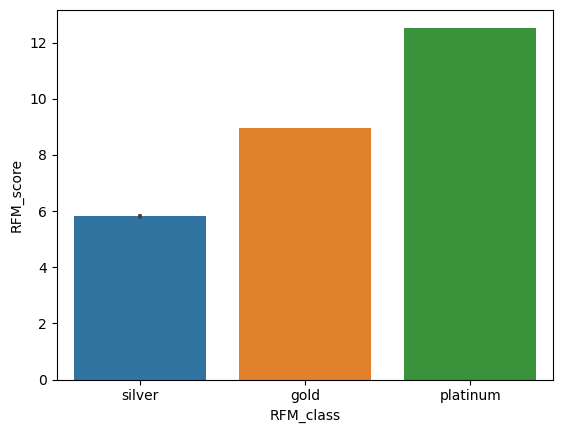

In [111]:
# barplot으로 RFM_class 별 평균 RFM_score 나타냅니다.
sns.barplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

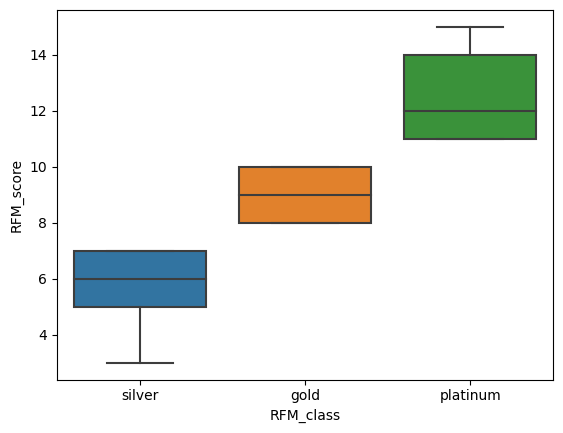

In [112]:
# boxplot으로 RFM_class 별 평균 RFM_score 나타냅니다.
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score")